# Project 4: Predict West Nile Virus
### Section 5. Model Exploration

## Problem Statement

1. As an employee of Disease And Treatment Agency, division of Societal Cures In Epidemiology and New Creative Engineering (DATA-SCIENCE), we are tasked to better understand the mosquito population and advise on appropriate interventions which are beneficial and cost-effective for the city.


2. Through this project, we hope to:
- Identify features which are most important to predict presence of West Nile Virus (which can be done by ranking the coefficients of each feature in a logistic regression model)
- Predict the probability of West Nile Virus by location to provide decision makers an effective plan to deploy pesticides throughout the city, which consequently can help to reduce cost.

## Import Libraries

In [23]:
#!pip install shapely
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
# from shapely import geometry
# from shapely.geometry import Point, Polygon
# import geopandas as gpd
# from datetime import timedelta
# import math

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier, VotingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics
from sklearn.metrics import (confusion_matrix, plot_confusion_matrix, classification_report, 
                             plot_roc_curve, roc_auc_score, accuracy_score, precision_score, 
                             recall_score, f1_score) #precision_recall_curve
from imblearn.over_sampling import SMOTE

## Load Data

In [24]:
# Load datasets
df = pd.read_csv('../data/final_df.csv', index_col='Unnamed: 0')

### Split into train and test (Kaggle) data

In [25]:
# Split into train and test (kaggle) data 
train = df[df['dataset']=='train'].copy()
test = df[df['dataset']=='test'].copy()
print(train.shape)
print(test.shape)

(8304, 240)
(43035, 240)


In [26]:
train.drop(columns='dataset', inplace=True)
test.drop(columns='dataset', inplace=True)

In [27]:
train.describe()

,latitude,longitude,tavg,preciptotal,stnpressure,resultdir,avgspeed,is_spray,stnpressure_7,stnpressure_10,...,codesum_TSRA BR HZ VCTS,codesum_TSRA FG+ BR HZ,codesum_TSRA RA,codesum_TSRA RA BR,codesum_TSRA RA BR HZ,codesum_TSRA RA BR HZ VCTS,codesum_TSRA RA BR VCTS,codesum_TSRA RA VCTS,codesum_VCTS,wnvpresent
count,8304.000000,8304.000000,8304.000000,8304.000000,8304.000000,8304.000000,8304.000000,8304.000000,8304.000000,8304.000000,...,8304.000000,8304.0,8304.000000,8304.000000,8304.0,8304.0,8304.000000,8304.0,8304.000000,8304.000000
mean,41.845800,-87.696229,72.093931,0.182431,29.262110,17.842245,7.476903,0.008911,29.277200,29.265990,...,0.006142,0.0,0.029383,0.037211,0.0,0.0,0.010597,0.0,0.003974,0.055034
std,0.106658,0.084440,7.630330,0.470450,0.118606,9.433945,2.543438,0.093984,0.126573,0.142227,...,0.078132,0.0,0.168889,0.189290,0.0,0.0,0.102402,0.0,0.062918,0.228060
min,41.644612,-87.930995,50.000000,0.000000,28.890000,1.000000,2.100000,0.000000,28.890000,28.910000,...,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000
25%,41.750498,-87.752411,69.000000,0.000000,29.180000,8.000000,5.800000,0.000000,29.210000,29.180000,...,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000
50%,41.862292,-87.696269,73.000000,0.000000,29.260000,19.000000,7.100000,0.000000,29.280000,29.260000,...,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000
75%,41.947227,-87.648064,78.000000,0.160000,29.340000,25.000000,9.400000,0.000000,29.380000,29.360000,...,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000
max,42.017430,-87.531635,87.000000,3.970000,29.650000,36.000000,16.300000,1.000000,29.650000,29.650000,...,1.000000,0.0,1.000000,1.000000,0.0,0.0,1.000000,0.0,1.000000,1.000000


In [28]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8304 entries, 0 to 8303
Columns: 239 entries, latitude to wnvpresent
dtypes: float64(11), int64(228)
memory usage: 15.2 MB


### Further Split Train Data into Train and Holdout

In [29]:
# Split train data into X (all features except wnvpresent) and y (wnvpresent)
features = [col for col in train.columns if col != 'wnvpresent']
X = train[features]
y = train['wnvpresent']

In [30]:
X.columns[X.isna().any()].tolist()

[]

In [31]:
y.value_counts(normalize = True)

0.0    0.944966
1.0    0.055034
Name: wnvpresent, dtype: float64

- wnvpresent is highly inbalance, with only about 5.5% of the data points having West Nile Virus. 
    - It is important to stratify proportionally to ensure that our train and holdout dataset have about the same proportion of presence and absence of West Nile Virus.
    - We also need to use SMOTE as the accuracy of our models without SMOTE is about 95% (i.e. close to the proportion of absence of WNV)

In [32]:
# Further split train data into train and holdout data
X_train, X_holdout, y_train, y_holdout = train_test_split(
    X, 
    y,
    stratify = y,
    random_state=42
)

In [33]:
# Scale our data
ss = StandardScaler()
Xs_train = ss.fit_transform(X_train)
Xs_holdout = ss.transform(X_holdout)

## Create synthetic data with SMOTE

In [102]:
# create synthetic data for train set
sm = SMOTE()
Xsm_train, ysm_train = sm.fit_resample(Xs_train, y_train)

In [103]:
Xsm_train.shape

(11770, 238)

## Model Exploration

### Metrics to Evaluate Models

In [36]:
# Creating a summary dataframe.
summary_df = pd.DataFrame(columns=[
    'model', 
    'best_score', 
    'train_score',
    'holdout_score',
    'sensitivity',
    'specificity',
    'precision',
    'f1_score',
    'best_params', 
])

In [37]:
summary_df

,model,best_score,train_score,holdout_score,sensitivity,specificity,precision,f1_score,best_params


In [38]:
def model_metrics(gs, X_train, y_train, X_test, y_test, modelname):
    '''Generates confusion matrix and adds scores to summary_df'''
    
    #Generate confusion matrix
    y_pred = gs.predict(X_test)
    confusion_matrix(y_test, # True values.
                     y_pred)  # Predicted values.
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel();
    y_train_pred_prob = gs.predict_proba(X_train)[:,1]
    y_test_pred_prob = gs.predict_proba(X_test)[:,1]
    
    summary_df_rows = summary_df.shape[0]
    # Adding the scores into summary_df
    summary_df.loc[summary_df_rows] = [
        modelname,
        #'CountVec/LogisticRegression',
        round(gs.best_score_, 3),
        round(metrics.roc_auc_score(y_train, y_train_pred_prob),3),
        round(metrics.roc_auc_score(y_test, y_test_pred_prob),3),
        round(metrics.recall_score(y_test, y_pred),3),
        round(tn/(tn+fp),3),
        round(tp / (tp + fp), 3),
        round(metrics.f1_score(y_test, y_pred),3),
        str(gs.best_params_),
    ]
    
    
    
    # Plot Confusion Matrix
    plot_confusion_matrix(gs, X_test, y_test, cmap='Blues', 
                          display_labels=['WNV Present', 'WNV Not Present'],
                          normalize='true');  
    plt.title(label=modelname, fontsize=14)
    plt.grid(False)

In [39]:
def model_metrics_2(gs, X_train, y_train, X_test, y_test, modelname):
    '''Generates confusion matrix and adds scores to summary_df'''
    
    #Generate confusion matrix
    y_pred = gs.predict(X_test)
    confusion_matrix(y_test, # True values.
                     y_pred)  # Predicted values.
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel();
    
    # y_train_pred_prob = gs.predict_proba(X_train)[:,1]
    # y_test_pred_prob = gs.predict_proba(X_test)[:,1]
    
    summary_df_rows = summary_df.shape[0]
    # Adding the scores into summary_df
    summary_df.loc[summary_df_rows] = [
        modelname,
        #'CountVec/LogisticRegression',
        round(gs.best_score_, 3),
        round(gs.score(X_train, y_train), 3),
        round(gs.score(X_test, y_test), 3),
        # round(metrics.roc_auc_score(y_train, y_train_pred_prob),3),
        # round(metrics.roc_auc_score(y_test, y_test_pred_prob),3),
        round(metrics.recall_score(y_test, y_pred),3),
        round(tn/(tn+fp),3),
        round(tp / (tp + fp), 3),
        round(metrics.f1_score(y_test, y_pred),3),
        str(gs.best_params_),
    ]
        
    # Plot Confusion Matrix
    plot_confusion_matrix(gs, X_test, y_test, cmap='Blues', 
                          display_labels=['WNV Present', 'WNV Not Present'],
                          normalize='true');  
    plt.title(label=modelname, fontsize=14)
    plt.grid(False)

### Checking for the importance of using SMOTE

We realize that the positive of interest, WNV, only appears in about 6% of our dataset. There might not be enough true positives to train our modelling. We will therefore use SMOTE , Synthetic Minority Oversampling TEchnique to attempt to overcome this deficit.

### Basic Logistic Regression w/o SMOTE

In [196]:
# Instantiate model
logreg = LogisticRegression()

# Fit model
logreg.fit(Xs_train, y_train)

print(f'Logistic Regression Intercept: {logreg.intercept_}')


Logistic Regression Intercept: [-5.18323133]


C:\Users\Asus\anaconda3\envs\dsi\envs\dsi27tf\lib\site-packages\sklearn\linear_model\_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


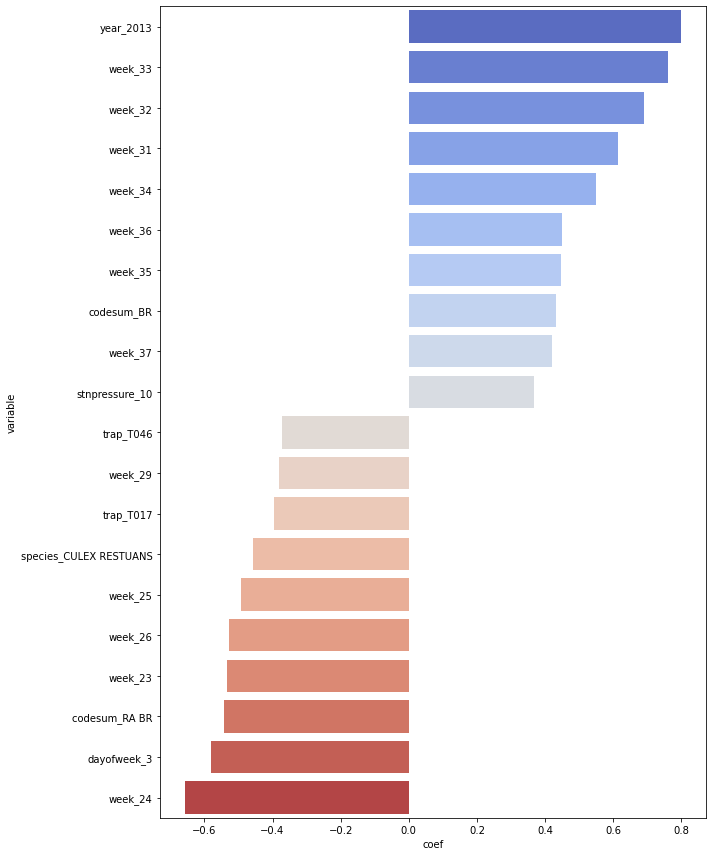

In [130]:
logreg.score(Xs_train, y_train), logreg.score(Xs_holdout, y_holdout)

(0.9449261400128453, 0.9436416184971098)

In [131]:
# Summary scores of CountVectorizer and LogisticRegression.
print("LogisticRegression summary of accuracy scores:")
#print(f"GridSearchCV best accuracy = {round(gs_pipe.best_score_, 3)}")
print("\nUsing GridSearchCV best params suggested,")
print(f"Training corpus accuracy = {round(logreg.score(X_train, y_train), 3)}")
print(f"Testing corpus accuracy = {round(logreg.score(X_holdout, y_holdout), 3)}")

LogisticRegression summary of accuracy scores:

Using GridSearchCV best params suggested,
Training corpus accuracy = 0.055
Testing corpus accuracy = 0.055


C:\Users\Asus\anaconda3\envs\dsi\envs\dsi27tf\lib\site-packages\sklearn\base.py:444: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
C:\Users\Asus\anaconda3\envs\dsi\envs\dsi27tf\lib\site-packages\sklearn\base.py:444: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


In [132]:
con1 = confusion_matrix(y_holdout, preds_logreg)

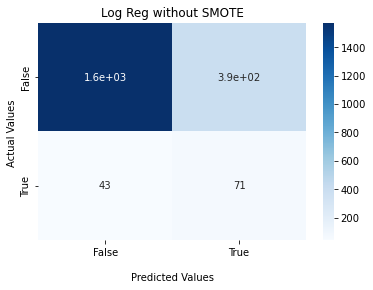

In [133]:
ax = sns.heatmap(con1, annot=True, cmap='Blues')

ax.set_title('Log Reg without SMOTE');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()

In [134]:
# Get predictions, confusion matrix
preds_logreg = logreg.predict(Xs_holdout)
# Save confusion matrix values
tn, fp, fn, tp = confusion_matrix(y_holdout, preds_logreg).ravel()
# Calculate the specificity, sensitivity, precision, f1 score
acc = (tn + tp) / (tn + fp + fn + tp)
sens = tp / (tp + fn)
spec = tn / (tn + fp)
prec = tp / (tp + fp)
f1 = 2 * (prec*sens) / (prec + sens)

In [135]:
acc

0.9436416184971098

In [136]:
sens

0.09649122807017543

In [137]:
spec

0.9928644240570846

In [138]:
prec

0.44

In [139]:
f1

0.15827338129496402

In [ ]:
summary_df.loc[summary_df_rows] = [
    modelname,
    #'CountVec/LogisticRegression',
    round(gs.best_score_, 3),
    round(gs.score(X_train, y_train), 3),
    round(gs.score(X_test, y_test), 3),
    # round(metrics.roc_auc_score(y_train, y_train_pred_prob),3),
    # round(metrics.roc_auc_score(y_test, y_test_pred_prob),3),
    round(metrics.recall_score(y_test, y_pred),3),
    round(tn/(tn+fp),3),
    round(tp / (tp + fp), 3),
    round(metrics.f1_score(y_test, y_pred),3),
    str(gs.best_params_),
]

In [140]:
summary_df = pd.DataFrame(columns=[
    'model', 
    'best_score', 
    'train_score',
    'holdout_score',
    'sensitivity',
    'specificity',
    'precision',
    'f1_score',
    'best_params', 
])

### Basic Logistic Regression w/ SMOTE

In [195]:
# Instantiate model
logreg2 = LogisticRegression()

# Fit model
logreg2.fit(Xsm_train, ysm_train)

print(f'Logistic Regression Intercept: {logreg2.intercept_}')

Logistic Regression Intercept: [-4.06501527]


C:\Users\Asus\anaconda3\envs\dsi\envs\dsi27tf\lib\site-packages\sklearn\linear_model\_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


In [142]:
#log-reg of with-week data, with SMOTE
logreg2.score(Xsm_train, ysm_train), logreg2.score(Xs_holdout, y_holdout)

(0.8618521665250637, 0.7957610789980732)

In [143]:
# Get predictions, confusion matrix
preds_logreg2 = logreg2.predict(Xs_holdout)
# Save confusion matrix values
tn, fp, fn, tp = confusion_matrix(y_holdout, preds_logreg2).ravel()

In [144]:
# Calculate the specificity, sensitivity, precision, f1 score
acc = (tn + tp) / (tn + fp + fn + tp)
sens = tp / (tp + fn)
spec = tn / (tn + fp)
prec = tp / (tp + fp)
f1 = 2 * (prec*sens) / (prec + sens)

In [145]:
con2 = confusion_matrix(y_holdout, preds_logreg2)

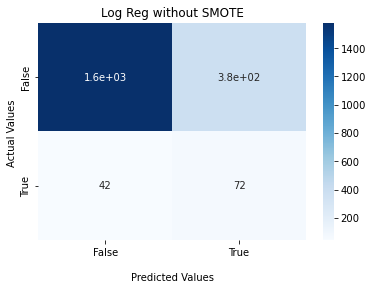

In [146]:
ax = sns.heatmap(con2, annot=True, cmap='Blues')

ax.set_title('Log Reg without SMOTE');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()

In [ ]:
# with weeks, with smote

In [147]:
acc

0.7957610789980732

In [148]:
sens

0.631578947368421

In [149]:
spec

0.8053007135575942

In [150]:
prec

0.15859030837004406

In [151]:
f1

0.2535211267605634

In [159]:
dataframe = pd.DataFrame(columns = ["modelname","acc", "sens", "spec", "prec", "f1"])

In [160]:
dataframe

,modelname,acc,sens,spec,prec,f1


We observe that the accuracy has decreased from 0.94364 to 0.79576, which means that we are not predicting true positives or true negatives accurately as often. However, we observe that our sensitivity, which is our true positive over the sum of true positive and false negatives, has increased from the low value of 0.09649 to 0.63158. That means that roughly 63.1% of the WNV positive traps can be caught by our model, compared to about 9.6% previously. Therefore, we would prefer to be using SMOTE in order to capture more WNV points for effective control. 

### Testing of importance of week data

In [171]:
df2 = df.copy()

In [172]:
df2.drop(columns = ['week_23',
 'week_24',
 'week_25',
 'week_26',
 'week_27',
 'week_28',
 'week_29',
 'week_30',
 'week_31',
 'week_32',
 'week_33',
 'week_34',
 'week_35',
 'week_36',
 'week_37',
 'week_38',
 'week_39',
 'week_40',
 'week_41',], inplace = True)

In [173]:
train2 = df2[df2['dataset']=='train'].copy()
test2 = df2[df2['dataset']=='test'].copy()
print(train2.shape)
print(test2.shape)

(8304, 221)
(43035, 221)


In [174]:
# Split train data into X (all features except wnvpresent) and y (wnvpresent)
features = [col for col in train2.columns if col != 'wnvpresent']
X2 = train2[features]
y2 = train2['wnvpresent']

In [175]:
X2.drop(columns = ["dataset"],inplace = True)

C:\Users\Asus\anaconda3\envs\dsi\envs\dsi27tf\lib\site-packages\pandas\core\frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [176]:
# Further split train data into train and holdout data
X_train2, X_holdout2, y_train2, y_holdout2 = train_test_split(
    X2, 
    y2,
    stratify = y2,
    random_state=42
)

In [177]:
# Scale our data
ss = StandardScaler()
Xs_train2 = ss.fit_transform(X_train2)
Xs_holdout2 = ss.transform(X_holdout2)

In [178]:
# create synthetic data for train set
sm = SMOTE()
Xsm_train2, ysm_train2 = sm.fit_resample(Xs_train2, y_train2)

In [194]:
logreg = LogisticRegression(max_iter=10_000)

# Fit model
logreg.fit(Xsm_train2, ysm_train2)

print(f'Logistic Regression Intercept: {logreg.intercept_}')

Logistic Regression Intercept: [-2.67842594]


In [181]:
#logreg of no-week data, with SMOTE
logreg.score(Xsm_train2, ysm_train2), logreg.score(Xs_holdout2, y_holdout2)

(0.8405267629566695, 0.7726396917148363)

In [185]:
# Get predictions, confusion matrix
preds_logreg_noweek = logreg.predict(Xs_holdout2)
# Save confusion matrix values
tn, fp, fn, tp = confusion_matrix(y_holdout2, preds_logreg_noweek).ravel()
# Calculate the specificity, sensitivity, precision, f1 score
acc = (tn + tp) / (tn + fp + fn + tp)
sens = tp / (tp + fn)
spec = tn / (tn + fp)
prec = tp / (tp + fp)
f1 = 2 * (prec*sens) / (prec + sens)



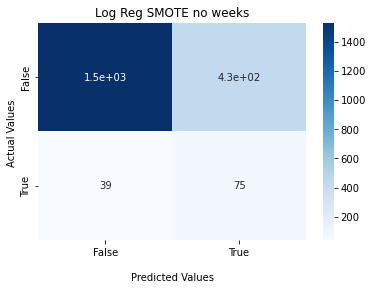

In [186]:
con3 = confusion_matrix(y_holdout2, preds_logreg_noweek)

ax = sns.heatmap(con3, annot=True, cmap='Blues')

ax.set_title('Log Reg SMOTE no weeks');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()

In [ ]:
# no weeks, with smote

In [187]:
acc

0.7726396917148363

In [188]:
sens

0.6578947368421053

In [189]:
spec

0.7793068297655453

In [190]:
prec

0.14763779527559054

In [191]:
f1

0.24115755627009647

Previously, accuracy was 0.7958, sensitivity was 0.6316, specificity  was 0.8053, precision was 0.1586, and f1 score was 0.2535.

Without weeks, our accuracy has dropped from 79.6% to 77.3%, but our sensitivity has increased to about 65.8% compared to 63.2%.

Given that the values are rather similar, we would be inclined to drop the weeks so that we can generalise our results to years where the weather patterns are not similar for the weeks within. Using weather data would be a better model to account for any climate changes or erratic weather.

In [197]:
df = df2.copy()

In [198]:
# Split into train and test (kaggle) data 
train = df[df['dataset']=='train'].copy()
test = df[df['dataset']=='test'].copy()
print(train.shape)
print(test.shape)

(8304, 221)
(43035, 221)


In [199]:
train.drop(columns='dataset', inplace=True)
test.drop(columns='dataset', inplace=True)

In [200]:
# Split train data into X (all features except wnvpresent) and y (wnvpresent)
features = [col for col in train.columns if col != 'wnvpresent']
X = train[features]
y = train['wnvpresent']

In [201]:
# Further split train data into train and holdout data
X_train, X_holdout, y_train, y_holdout = train_test_split(
    X, 
    y,
    stratify = y,
    random_state=42
)

In [202]:
# Scale our data
ss = StandardScaler()
Xs_train = ss.fit_transform(X_train)
Xs_holdout = ss.transform(X_holdout)

In [203]:
# create synthetic data for train set
sm = SMOTE()
Xsm_train, ysm_train = sm.fit_resample(Xs_train, y_train)

### Logistics Regression 

In [261]:
logreg = LogisticRegression(max_iter=10_000)

# Fit model
logreg.fit(Xsm_train, ysm_train)

print(f'Logistic Regression Intercept: {logreg.intercept_}')

Logistic Regression Intercept: [-2.66327546]


In [262]:
#logreg of no-week data, with SMOTE
logreg.score(Xsm_train, ysm_train), logreg.score(Xs_holdout, y_holdout)

(0.8355140186915888, 0.7716763005780347)

With Ridge CV

In [270]:
ridge = LogisticRegression(max_iter=10_000, penalty = 'l2', solver = 'liblinear')

# Fit model
ridge.fit(Xsm_train, ysm_train)

print(f'Logistic Regression Intercept: {logreg.intercept_}')

Logistic Regression Intercept: [-2.66327546]


In [271]:
#logreg of no-week data, with SMOTE
ridge.score(Xsm_train, ysm_train), ridge.score(Xs_holdout, y_holdout)

(0.835768903993203, 0.7716763005780347)

In [236]:
df.head()

,latitude,longitude,tavg,preciptotal,stnpressure,resultdir,avgspeed,is_spray,stnpressure_7,stnpressure_10,...,codesum_TSRA FG+ BR HZ,codesum_TSRA RA,codesum_TSRA RA BR,codesum_TSRA RA BR HZ,codesum_TSRA RA BR HZ VCTS,codesum_TSRA RA BR VCTS,codesum_TSRA RA VCTS,codesum_VCTS,wnvpresent,dataset
0,41.867108,-87.654224,74,0.0,29.39,18,6.5,0.0,29.34,29.34,...,0,0,0,0,0,0,0,0,0.0,train
1,41.867108,-87.654224,74,0.0,29.39,18,6.5,0.0,29.34,29.34,...,0,0,0,0,0,0,0,0,0.0,train
2,41.862292,-87.648860,74,0.0,29.39,18,6.5,0.0,29.34,29.34,...,0,0,0,0,0,0,0,0,0.0,train
3,41.896282,-87.655232,74,0.0,29.39,18,6.5,0.0,29.34,29.34,...,0,0,0,0,0,0,0,0,0.0,train
4,41.907645,-87.760886,74,0.0,29.39,18,6.5,0.0,29.34,29.34,...,0,0,0,0,0,0,0,0,0.0,train


In [247]:
df_col = df.drop(columns = ['wnvpresent', 'dataset'])

In [251]:
df_col.columns

Index(['latitude', 'longitude', 'tavg', 'preciptotal', 'stnpressure',
       'resultdir', 'avgspeed', 'is_spray', 'stnpressure_7', 'stnpressure_10',
       ...
       'codesum_TSRA BR', 'codesum_TSRA BR HZ VCTS', 'codesum_TSRA FG+ BR HZ',
       'codesum_TSRA RA', 'codesum_TSRA RA BR', 'codesum_TSRA RA BR HZ',
       'codesum_TSRA RA BR HZ VCTS', 'codesum_TSRA RA BR VCTS',
       'codesum_TSRA RA VCTS', 'codesum_VCTS'],
      dtype='object', length=219)

In [254]:
ridge_coef = pd.DataFrame(data=ridge.coef_[0],
                          index=df_col.columns,
                          columns=['coef'])


In [256]:
pd.set_option('display.max_rows', 219)

In [257]:
ridge_coef

,coef
latitude,-0.738620
longitude,-0.319309
tavg,0.708937
preciptotal,-0.965319
stnpressure,0.281647
resultdir,0.020674
avgspeed,-0.294450
is_spray,0.008507
stnpressure_7,0.357631
stnpressure_10,-0.108116


In [259]:
ridge_coef_0 = ridge_coef.loc[ridge_coef['coef'] == 0, :]
ridge_coef_0 

,coef
BCFG,0.0
year_2008,0.0
year_2010,0.0
year_2012,0.0
year_2014,0.0
trap_T002A,0.0
trap_T002B,0.0
trap_T065A,0.0
trap_T090A,0.0
trap_T090B,0.0


In [260]:
# Observations:
# We might want to take year out as it does not help us with using our modeling for future 
# purposes
# weeks might still have a reason since for each year the week will come by again

With Lasso CV

In [276]:
lasso = LogisticRegression(max_iter=10_000, penalty = 'l1', solver = 'liblinear')

# Fit model
lasso.fit(Xsm_train, ysm_train)

print(f'Logistic Regression Intercept: {logreg.intercept_}')

Logistic Regression Intercept: [-2.66327546]


In [277]:
#logreg of no-week data, with SMOTE
lasso.score(Xsm_train, ysm_train), lasso.score(Xs_holdout, y_holdout)

(0.8358538657604078, 0.7707129094412332)

In [278]:
lasso_coef = pd.DataFrame(data=lasso.coef_[0],
                          index=df_col.columns,
                          columns=['coef'])


In [279]:
lasso_coef

,coef
latitude,-0.829693
longitude,-0.583791
tavg,0.682029
preciptotal,-0.926049
stnpressure,0.201010
resultdir,0.027675
avgspeed,-0.384155
is_spray,0.009898
stnpressure_7,0.338941
stnpressure_10,-0.152528


In [281]:
lasso_0 = lasso_coef.loc[lasso_coef['coef'] == 0, :]
lasso_0

,coef
BR,0.0
VCTS,0.0
BCFG,0.0
FG,0.0
FG+,0.0
RA,0.0
year_2008,0.0
year_2010,0.0
year_2012,0.0
year_2014,0.0


With Elastic Net 

In [224]:
logreg = LogisticRegression(max_iter=10_000, penalty = 'elasticnet', solver = 'saga')

# Fit model
logreg.fit(Xsm_train, ysm_train)

print(f'Logistic Regression Intercept: {logreg.intercept_}')

ValueError: l1_ratio must be between 0 and 1; got (l1_ratio=None)

### Random Forest

In [204]:
rf = RandomForestClassifier(n_estimators=100)

In [205]:
rf_params = {
    'n_estimators': [100, 150, 200],
    'max_depth': [3, 5, 7],
    'max_features': ['sqrt', 'log2', 0.5,0.7],
    'min_samples_split': [5, 10, 15],
    'min_samples_leaf': [3, 4, 5],
    'ccp_alpha': [0, 0.01, 0.1, 1],
}

In [206]:
gs_rf_0 = GridSearchCV(rf, param_grid=rf_params, cv=5, n_jobs = -1)

In [207]:
gs_rf_0.fit(Xsm_train, ysm_train)


GridSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'ccp_alpha': [0, 0.01, 0.1, 1], 'max_depth': [3, 5, 7],
                         'max_features': ['sqrt', 'log2', 0.5, 0.7],
                         'min_samples_leaf': [3, 4, 5],
                         'min_samples_split': [5, 10, 15],
                         'n_estimators': [100, 150, 200]})

In [208]:
print(gs_rf_0.best_score_)
gs_rf_0.best_params_

0.9115548003398471


{'ccp_alpha': 0,
 'max_depth': 7,
 'max_features': 0.5,
 'min_samples_leaf': 3,
 'min_samples_split': 10,
 'n_estimators': 150}

In [228]:
gs_rf_0.best_estimator_[0]

DecisionTreeClassifier(ccp_alpha=0, max_depth=7, max_features=0.5,
                       min_samples_leaf=3, min_samples_split=10,
                       random_state=1588085344)

In [294]:
feature_names = gs_rf_0.best_estimator_[0].feature_names_in_

AttributeError: 'DecisionTreeClassifier' object has no attribute 'feature_names_in_'

In [282]:
importances = gs_rf_0.best_estimator_[1].feature_importances_

In [283]:
rf_params2 = {
    'n_estimators': [150],
    'max_depth': [7, 9,'none'],
    'max_features': [0.4,0.5, 0.6],
    'min_samples_split': [10],
    'min_samples_leaf': [1,2,3],
    'ccp_alpha': [0],
}

In [285]:
gs_rf_1 = GridSearchCV(rf, param_grid=rf_params2, cv=5, n_jobs = -1)

In [286]:
gs_rf_1.fit(Xsm_train, ysm_train)

C:\Users\Asus\anaconda3\envs\dsi\envs\dsi27tf\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
45 fits failed out of a total of 135.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
45 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Asus\anaconda3\envs\dsi\envs\dsi27tf\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Asus\anaconda3\envs\dsi\envs\dsi27tf\lib\site-packages\sklearn\ensemble\_forest.py", line 467, in fit
    for i, t in enumerate(trees)
  File "C:\Users\Asus\anaconda3\envs\dsi\envs\dsi27tf\lib\site-packages\joblib\parallel.py", line 1043, in __call__

GridSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'ccp_alpha': [0], 'max_depth': [7, 9, 'none'],
                         'max_features': [0.4, 0.5, 0.6],
                         'min_samples_leaf': [1, 2, 3],
                         'min_samples_split': [10], 'n_estimators': [150]})

In [287]:
print(gs_rf_1.best_score_)
gs_rf_1.best_params_

0.9339847068819033


{'ccp_alpha': 0,
 'max_depth': 9,
 'max_features': 0.4,
 'min_samples_leaf': 1,
 'min_samples_split': 10,
 'n_estimators': 150}

### Extra Trees

In [74]:
et = ExtraTreesClassifier(random_state=42)
et_params = {'n_estimators': [20, 25, 30, 35],
             'max_depth': [20, 30, 40, 50],
             'min_samples_leaf': [2, 3, 4],
            }

In [75]:
et_gs = GridSearchCV(et, 
                  param_grid=et_params, 
                  cv=5
                 )

In [76]:
et_gs.fit(Xsm_train, ysm_train);
et_gs.score(Xs_holdout, y_holdout)

0.9022157996146436

In [77]:
et_gs.best_estimator_

ExtraTreesClassifier(max_depth=50, min_samples_leaf=2, n_estimators=35,
                     random_state=42)

In [78]:
et_gs.best_params_

{'max_depth': 50, 'min_samples_leaf': 2, 'n_estimators': 35}

C:\Users\deang\anaconda3\envs\dsi\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


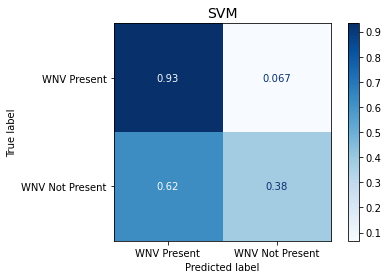

In [79]:
model_metrics(et_gs, Xsm_train, ysm_train, Xs_holdout, y_holdout, 'ExtraTrees')

### SVM

In [18]:
# C values to GridSearch over
svc_params = {
        'C': [10, 20, 30],
        'gamma':[0.01, 0.1], 
        'kernel' : ['rbf', 'sigmoid'],
        'probability': [True]
        }

In [19]:
# Instantiate and fit a gridsearch model
svc = SVC(max_iter=20000,
         verbose= 1)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

scv_gs = GridSearchCV(svc, svc_params, cv=cv)
scv_gs.fit(Xsm_train, ysm_train);
scv_gs.score(Xs_holdout, y_holdout)


[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]

0.9084778420038536

In [20]:
scv_gs.best_estimator_

SVC(C=20, gamma=0.01, max_iter=20000, probability=True, verbose=1)

In [21]:
scv_gs.best_params_

{'C': 20, 'gamma': 0.01, 'kernel': 'rbf', 'probability': True}

C:\Users\deang\anaconda3\envs\dsi\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


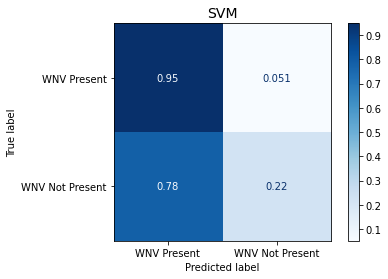

In [22]:
model_metrics(scv_gs, Xsm_train, ysm_train, Xs_holdout, y_holdout, 'SVM')

### AdaBoostClassifier

In [81]:
ada = AdaBoostClassifier(
    n_estimators = 100,
    learning_rate = 0.9
    # in general, if n_estimators is high, then learning_rate should be low
    # but we can use GridSearchCV
)
ada.fit(Xsm_train, ysm_train)
ada.score(Xs_holdout, y_holdout)

0.9099229287090559

In [82]:
ada = AdaBoostClassifier(base_estimator=DecisionTreeClassifier())
ada_params = {
    'n_estimators': [50, 100, 150],
    'base_estimator__max_depth': [1,2],
    'learning_rate': [.8, .9, 1.]
    # you can also tune by all hyperparameters of DecisionTree
}
ada_gs = GridSearchCV(
    ada, 
    param_grid=ada_params, 
    cv=5
)
ada_gs.fit(Xsm_train, ysm_train)
ada_gs.score(Xs_holdout, y_holdout)

0.9291907514450867

In [83]:
tn, fp, fn, tp = confusion_matrix(y_holdout, ada_gs.predict(Xs_holdout)).ravel()

In [84]:
sensitivity = tp / (tp + fn)
sensitivity

0.12280701754385964

In [85]:
precision = tp / (tp + fp)
precision

0.22950819672131148

C:\Users\deang\anaconda3\envs\dsi\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


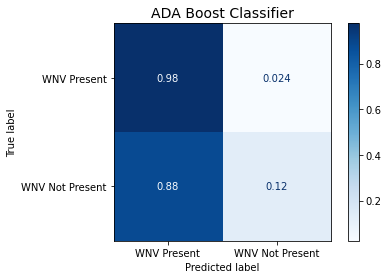

In [86]:
model_metrics(ada_gs, Xsm_train, ysm_train, Xs_holdout, y_holdout, 'ADA Boost Classifier')

In [87]:
summary_df

,model,best_score,train_score,holdout_score,sensitivity,specificity,precision,f1_score,best_params
0,SVM,0.968,0.999,0.731,0.219,0.949,0.198,0.208,"{'C': 20, 'gamma': 0.01, 'kernel': 'rbf', 'pro..."
1,SVM,0.947,0.996,0.848,0.377,0.933,0.246,0.298,"{'max_depth': 50, 'min_samples_leaf': 2, 'n_es..."
2,ADA Boost Classifier,0.956,0.997,0.790,0.123,0.976,0.230,0.160,"{'base_estimator__max_depth': 2, 'learning_rat..."


In [89]:
print(ada_gs.best_score_)
ada_gs.best_params_

0.9563296516567543


{'base_estimator__max_depth': 2, 'learning_rate': 1.0, 'n_estimators': 100}

<AxesSubplot:>

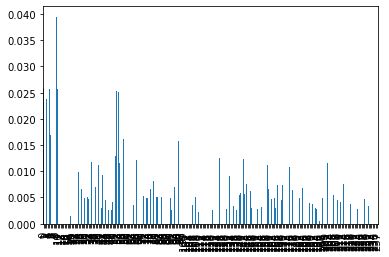

In [90]:
pd.Series(ada_gs.best_estimator_.feature_importances_).plot.bar()

### Gradient Boosting Classifier

In [94]:
gboost = GradientBoostingClassifier()
gboost_params = {
    'max_depth': [2, 3, 4],
    'n_estimators': [100, 125, 150],
    'learning_rate': [.08, .1, .12]
}
gb_gs = GridSearchCV(
    gboost, 
    param_grid=gboost_params, 
    cv=3
)
gb_gs.fit(Xsm_train, ysm_train)
gb_gs.score(Xs_holdout, y_holdout)

0.9359344894026975

In [95]:
print(gb_gs.best_score_)
gb_gs.best_params_

0.9548892635839294


{'learning_rate': 0.12, 'max_depth': 4, 'n_estimators': 150}

In [96]:
#0.955	0.996	0.853	

In [97]:
tn, fp, fn, tp = confusion_matrix(y_holdout, gb_gs.predict(Xs_holdout)).ravel()

In [98]:
sensitivity = tp / (tp + fn)
sensitivity

0.13157894736842105

In [99]:
specificity = tn / (tn + fp)
specificity

0.9826707441386341

In [100]:
precision = tp / (tp + fp)
precision

0.30612244897959184

In [101]:
confusion_matrix(y_holdout, gb_gs.predict(Xs_holdout))

array([[1928,   34],
       [  99,   15]], dtype=int64)

C:\Users\deang\anaconda3\envs\dsi\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


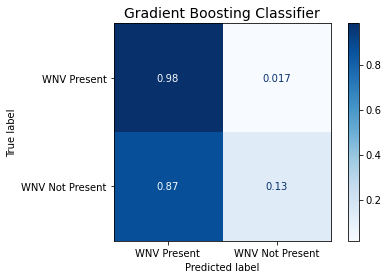

In [102]:
model_metrics(gb_gs, Xsm_train, ysm_train, Xs_holdout, y_holdout, 'Gradient Boosting Classifier')

In [103]:
summary_df

,model,best_score,train_score,holdout_score,sensitivity,specificity,precision,f1_score,best_params
0,SVM,0.968,0.999,0.731,0.219,0.949,0.198,0.208,"{'C': 20, 'gamma': 0.01, 'kernel': 'rbf', 'pro..."
1,SVM,0.947,0.996,0.848,0.377,0.933,0.246,0.298,"{'max_depth': 50, 'min_samples_leaf': 2, 'n_es..."
2,ADA Boost Classifier,0.956,0.997,0.790,0.123,0.976,0.230,0.160,"{'base_estimator__max_depth': 2, 'learning_rat..."
3,Gradient Boosting Classifier,0.955,0.996,0.856,0.132,0.983,0.306,0.184,"{'learning_rate': 0.12, 'max_depth': 4, 'n_est..."


### Neural Network

In [52]:
def model_metrics_nn(model, modelname):
    '''Generates confusion matrix and adds scores to summary_df'''
    #Generate confusion matrix
    tn, fp, fn, tp = confusion_matrix(ysm_train, model.predict_classes(Xsm_train)).ravel();
    acc_train = (tn + tp) / (tn + fp + fn + tp)

    y_pred = model.predict_classes(Xs_holdout)
    confusion_matrix(y_holdout, # True values.
                     y_pred)  # Predicted values.
    tn, fp, fn, tp = confusion_matrix(y_holdout, y_pred).ravel();
    acc = (tn + tp) / (tn + fp + fn + tp)
    sens = tp / (tp + fn)
    spec = tn / (tn + fp)
    prec = tp / (tp + fp)
    f1_score = 2 * (prec*sens) / (prec + sens)


    summary_df_rows = summary_df.shape[0]
    # Adding the scores into summary_df
    summary_df.loc[summary_df_rows] = [
        modelname,
        '',
        round(acc_train,3), # accuracy of train
        round(acc,3), # accuracy of holdout
        round(sens,3), # sensitivity of holdout
        round(spec,3), # specificity of holdout
        round(prec,3), # specificity of holdout
        round(f1_score,3), # f1 score of holdout
        '',
    ]

In [53]:
model = Sequential()
model.add(Dense(64,
                input_shape=(238,),
                activation='relu'))
model.add(Dense(1, activation='sigmoid'))

NameError: name 'Sequential' is not defined

In [ ]:
model.compile(loss='binary_crossentropy', metrics=['accuracy'], optimizer='adam')

In [ ]:
history = model.fit(Xsm_train, ysm_train, validation_data=(Xs_holdout, y_holdout), epochs=2, batch_size=512, verbose=0)

In [ ]:
plt.plot(history.history['loss'], label='Train loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend();

In [ ]:
plt.plot(history.history['accuracy'], label='Train accuracy')
plt.plot(history.history['val_accuracy'], label='Val accuracy')
plt.legend();

In [54]:
model_metrics_nn(model, 'Neural Network')

NameError: name 'model' is not defined

In [ ]:
summary_df

### Neural Network with Dropout

In [ ]:
Xsm_train.shape[1]

In [ ]:
# the turn-on and off are during each mini-batch run

from tensorflow.keras.layers import Dropout

model_dropout = Sequential()

n_input = Xsm_train.shape[1]
n_hidden = n_input

model_dropout.add(Dense(n_hidden, input_dim=n_input, activation='relu'))
model_dropout.add(Dropout(0.2))
model_dropout.add(Dense(64, activation='relu'))
model_dropout.add(Dropout(0.2))
model_dropout.add(Dense(1, activation='sigmoid'))

model_dropout.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# history = model.fit(Xsm_train, ysm_train, validation_data=(Xs_holdout, y_holdout), epochs=2, batch_size=512, verbose=0)
history_dropout = model_dropout.fit(
    Xsm_train,
    ysm_train,
    validation_data=(Xs_holdout, y_holdout), 
    epochs=1,
    batch_size=None
)

In [ ]:
model_metrics_nn(model_dropout, 'Neural Network with Dropout')

In [ ]:
summary_df

### Neural Network with Early Stopping

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

# Build model using early stopping
model_es = Sequential()

n_input = Xsm_train.shape[1]

model_es.add(Dense(64, input_dim=n_input, activation='relu'))
model_es.add(Dense(1, activation='sigmoid'))

model_es.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

early_stop = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=1, mode='auto')

history_es = model_es.fit(
    Xsm_train,
    ysm_train,
    validation_data=(Xs_holdout, y_holdout),
    epochs=1,
    batch_size=None,
    callbacks=[early_stop]
)

In [ ]:
model_metrics_nn(model_es, 'Neural Network with Early Stopping')

In [ ]:
summary_df

### AUC-ROC Curve

C:\Users\deang\anaconda3\envs\dsi\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)
C:\Users\deang\anaconda3\envs\dsi\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)
C:\Users\deang\anaconda3\envs\dsi\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecat

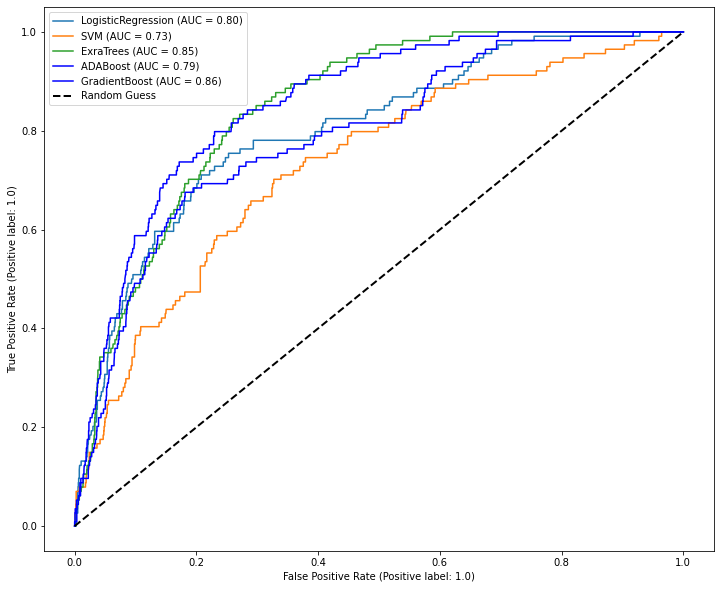

In [104]:
fig, ax = plt.subplots(1, 1, figsize=(12,10))
plot_roc_curve(logreg, Xs_holdout, y_holdout, ax=ax, name='LogisticRegression')
plot_roc_curve(scv_gs, Xs_holdout, y_holdout, ax=ax, name='SVM')
plot_roc_curve(et_gs, Xs_holdout, y_holdout, ax=ax, name='ExraTrees')
plot_roc_curve(ada_gs, Xs_holdout, y_holdout, ax=ax, name='ADABoost', color='blue')
plot_roc_curve(gb_gs, Xs_holdout, y_holdout, ax=ax, name='GradientBoost', color='blue')
plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--', label='Random Guess')
plt.legend()